# Comparing CML and BIDS

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import cmlreaders as cml
from cmldask import CMLDask as da
from dask.distributed import wait, as_completed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import xarray as xr
import scipy as scp
import re
from scipy import stats
from ptsa.data.timeseries import *
from statsmodels.stats.multitest import multipletests
import pyedflib
from mne_bids import get_entity_vals
from ReportRawEEG import *
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
%matplotlib inline
import mne
from mne_bids import BIDSPath, read_raw_bids
from ReportRawEEG import _all_exist

In [2]:
### ACROSS MULTIPLE SUBJECTS AND SESSIONS
bids_root = "/data/LTP_BIDS/"
subjects = get_entity_vals(bids_root, "subject")

In [3]:
client = da.new_dask_client_slurm(
    job_name="CML_BIDS_comparison",
    memory_per_job="100GB",
    max_n_jobs=20,
    queue="RAM",
    local_directory="~/scratch",
    log_directory=os.path.expanduser("~/log_directory")
)

Unique port for zrentala is 51618
{'dashboard_address': ':51618'}
To view the dashboard, run: 
`ssh -fN zrentala@rhino2.psych.upenn.edu -L 8000:192.168.86.143:51618` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


## Compare LTP

In [4]:
# get necessary subjects
max_subjects = 10
# experiments = ["ValueCourier", "ltpFR", "ltpFR2", "VFFR"]
experiments = ["ValueCourier", "VFFR"]

subjects_to_exclude = {"LTP001", "LTP9992", "LTP9993"} 

df = cml.get_data_index()

df_exp = df[df["experiment"].isin(experiments)].copy()

# remove excluded subjects up front
df_exp = df_exp[~df_exp["subject"].isin(subjects_to_exclude)].copy()

dfs = []

for exp in experiments:
    df_this = df_exp[df_exp["experiment"] == exp]

    subjects = (
        df_this["subject"]
        .drop_duplicates()
        .sort_values()      # deterministic
        .head(max_subjects)
    )

    df_keep = df_this[df_this["subject"].isin(subjects)].copy()
    dfs.append(df_keep)

df_subset = pd.concat(dfs, ignore_index=True)

### Raw and Epoched EEG

In [6]:
# epoched by type
bids_root = "/data/LTP_BIDS/"
subjects = get_entity_vals(bids_root, "subject")
out_path = "ltp_results/"
futures = []
REL_START, REL_STOP = 200, 1000
BUFFER_MS = 1000
# evs_type = ["WORD"]
evs_type = None
tmin = (-BUFFER_MS)
tmax = ((REL_STOP + BUFFER_MS))
future_meta = {} 
futures_eeg = []
for i, row in df_subset.iterrows():
    sub = row["subject"]
    exp = row["experiment"]
    sess = row["session"]
    try:
        process_raw_signals(sub, exp, sess, bids_root, out_path)
    except Exception as e:
        print(e)
    try:
        process_epoched_signals(sub, exp, sess, evs_type, tmin, tmax, bids_root, out_path, verbose=True)
    except Exception as e:
        print(e)
#     fut = client.submit(
#         process_epoched_signals_by_type,
#         sub, exp, sess, evs_type, tmin, tmax, bids_root, out_path
#     )

#     futures_eeg.append(fut)
#     future_meta[fut.key] = (sub, exp, sess)
#     # if i < 15:
    #     bre

FileNotFoundError: Root directory does not exist: /home1/maint/LTP_BIDS

In [2]:
# run futures 
from dask.distributed import as_completed

all_df_raw = []
all_df_raw_summary = []
all_df_time = []

n_done, n_fail = 0, 0

for fut in as_completed(futures_eeg):
    sub, exp, sess = future_meta.get(fut.key, ("<unknown>", "<unknown>", "<unknown>"))

    try:
        out = fut.result()

        if out.get("skipped"):
            print(f"[SKIP] {sub} | {exp} | {sess}")
            continue

        if out["df_raw"] is not None and not out["df_raw"].empty:
            all_df_raw.append(out["df_raw"])

        if out["df_raw_summary"] is not None and not out["df_raw_summary"].empty:
            all_df_raw_summary.append(out["df_raw_summary"])

        if out["df_time"] is not None and not out["df_time"].empty:
            all_df_time.append(out["df_time"])

        n_done += 1
        print(f"[DONE] {sub} | {exp} | {sess}  ({n_done})")

    except Exception as e:
        n_fail += 1
        print(f"[FAIL] {sub} | {exp} | {sess}  -> {e}  ({n_fail})")

NameError: name 'futures_eeg' is not defined

### Behavioral Events

In [5]:
# run behavioral comparison
bids_root = "/data/LTP_BIDS/"
# subjects = get_entity_vals(bids_root, "subject")
out_path = "ltp_results/"
futures_beh = []
evs_type = None
for i, row in df_subset.iterrows():
    sub = row["subject"]
    exp = row["experiment"]
    sess = row["session"]
    process_events(sub, exp, sess, evs_type, bids_root, out_path)
    
    # futures_beh.append(client.submit(process_events, sub, exp, sess, evs_type, bids_root, out_path))

[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-0/eeg/sub-LTP606_ses-0_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 0
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-1/eeg/sub-LTP606_ses-1_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 1
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-2/eeg/sub-LTP606_ses-2_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 2
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-3/eeg/sub-LTP606_ses-3_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 3
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-4/eeg/sub-LTP606_ses-4_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 4
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP606/ses-5/eeg/sub-LTP606_ses-5_task-valuecourier_events.tsv
Successfully processed LTP606 | ValueCourier | 5
[BIDS] Loaded events from: /data/LTP_BIDS/sub-LTP607

In [11]:
import os

in_path = "ltp_results/"
out_path = "ltp_final/"
DELETE_SOURCE_FILES = False  # set True when ready

# --------------------------------------------------
# Ensure output directory exists
# --------------------------------------------------
os.makedirs(out_path, exist_ok=True)

# --------------------------------------------------
# 1️⃣ Define file categories
# --------------------------------------------------
FILE_CATEGORIES = {
    "df_raw": "df_raw_",
    "df_raw_summary": "df_raw_summary_",
    "df_time": "df_time_",
    "df_behavior_summary": "df_behavior_summary_",
}

category_files = {key: [] for key in FILE_CATEGORIES}

# --------------------------------------------------
# 2️⃣ Walk INPUT directory and categorize
# --------------------------------------------------
for dirpath, _, filenames in os.walk(in_path):

    for f in filenames:
        if not f.endswith(".csv"):
            continue

        
        full_path = os.path.join(dirpath, f)

        for key, prefix in FILE_CATEGORIES.items():
            if f.startswith(prefix):
                category_files[key].append(full_path)
                break

# --------------------------------------------------
# 3️⃣ Load, concatenate, and save (if files exist)
# --------------------------------------------------
all_dataframes = {}

print("\nProcessing categories...\n")

for key, file_list in category_files.items():

    if len(file_list) == 0:
        print(f"Skipping {key} (no files found)")
        continue

    print(f"Processing {key} ({len(file_list)} files)...")

    try:
        df_all = load_and_concat(file_list)
        all_dataframes[key] = df_all

        outfile = os.path.join(out_path, f"{key}_all.csv")
        df_all.to_csv(outfile, index=False)
        print(f"Saved → {outfile}")

        if DELETE_SOURCE_FILES:
            delete_source_files(file_list, DELETE_SOURCE_FILES)

    except Exception as e:
        print(f"Failed processing {key}: {e}")

# --------------------------------------------------
# 4️⃣ Summary
# --------------------------------------------------
print("\n" + "=" * 50)
print("Summary:")
for key, df in all_dataframes.items():
    print(f"{key}_all: {len(df)} rows")
print("=" * 50)

if DELETE_SOURCE_FILES:
    print("\nSource file deletion complete!")
else:
    print("\nSource files retained (set DELETE_SOURCE_FILES=True to delete)")



Processing categories...

Skipping df_raw (no files found)
Skipping df_raw_summary (no files found)
Skipping df_time (no files found)
Processing df_behavior_summary (111 files)...
Removed 1 duplicate rows
Saved → ltp_final/df_behavior_summary_all.csv

Summary:
df_behavior_summary_all: 110 rows

Source files retained (set DELETE_SOURCE_FILES=True to delete)


In [ ]:
# load eeg
# df_raw_all = pd.read_csv("df_raw_all.csv")
df_raw_summary_all = pd.read_csv("df_raw_summary_all.csv")
df_time_all = pd.read_csv("df_time_all.csv")
df_behavior_summary_all = pd.read_csv("df_behavior_summary_all.csv")

In [ ]:
# plot mean and std difference
plot_comp_results(df_time_all, "mean_abs_time_diff", "std_time_diff", col_label="Mean Abs Time Diff")

In [ ]:
# plot mse
plot_comp_results(df_time_all, "mse_time", col_label="MSE Time")

In [ ]:
plot_comp_results(df_raw_summary_all, "mean_abs_diff", "std_diff", col_label="Mean Abs Signal Diff")

In [ ]:
# plot mse
plot_comp_results(df_raw_summary_all, "mse", col_label="MSE Raw Signal")

In [ ]:
# plot n_channels diff
plot_comp_results(df_raw_summary_all, "n_exact_diff_channels")
plot_comp_results(df_raw_summary_all, "n_close_diff_channels")

In [ ]:
plot_comp_results(df_behavior_summary_all, "n_differing_columns")

## Compare RAM

In [2]:
# get necessary subjects
max_subjects = 10
# experiments = ["ValueCourier", "ltpFR", "ltpFR2", "VFFR"]
experiments = ["catFR1", "catFR2", "FR1", "FR2", "PAL1", "PAL2", "pyFR", "RepFR1", "YC1", "YC2"]

subjects_to_exclude = {"LTP001", "LTP9992", "LTP9993"}  # <-- your list here

df = cml.get_data_index()

df_exp = df[df["experiment"].isin(experiments)].copy()

# remove excluded subjects up front
df_exp = df_exp[~df_exp["subject"].isin(subjects_to_exclude)].copy()

dfs = []

for exp in experiments:
    df_this = df_exp[df_exp["experiment"] == exp]

    subjects = (
        df_this["subject"]
        .drop_duplicates()
        .sort_values()      # deterministic
        .head(max_subjects)
    )

    df_keep = df_this[df_this["subject"].isin(subjects)].copy()
    dfs.append(df_keep)

df_subset = pd.concat(dfs, ignore_index=True)

### Raw and Epoched Signals

In [ ]:
# epoched by type
bids_root = "/data/LTP_BIDS/"
subjects = get_entity_vals(bids_root, "subject")
out_path = "raw_results_type/"
futures = []
REL_START, REL_STOP = 200, 1000
BUFFER_MS = 1000
# evs_type = ["WORD"]
evs_type = None
tmin = (-BUFFER_MS)
tmax = ((REL_STOP + BUFFER_MS))
future_meta = {} 
futures_eeg = []
for i, row in df_subset.iterrows():
    sub = row["subject"]
    exp = row["experiment"]
    sess = row["session"]
    try:
        process_raw_signals(sub, exp, sess, bids_root, out_path)
    except Exception as e:
        print(e)
    try:
        process_epoched_signals_by_type(sub, exp, sess, evs_type, tmin, tmax, bids_root, out_path, verbose=True)
    except Exception as e:
        print(e)
#     fut = client.submit(
#         process_epoched_signals_by_type,
#         sub, exp, sess, evs_type, tmin, tmax, bids_root, out_path
#     )

#     futures_eeg.append(fut)
#     future_meta[fut.key] = (sub, exp, sess)
#     # if i < 15:
    #     bre

In [ ]:
# run futures 
from dask.distributed import as_completed

all_df_raw = []
all_df_raw_summary = []
all_df_time = []

n_done, n_fail = 0, 0

for fut in as_completed(futures_eeg):
    sub, exp, sess = future_meta.get(fut.key, ("<unknown>", "<unknown>", "<unknown>"))

    try:
        out = fut.result()

        if out.get("skipped"):
            print(f"[SKIP] {sub} | {exp} | {sess}")
            continue

        if out["df_raw"] is not None and not out["df_raw"].empty:
            all_df_raw.append(out["df_raw"])

        if out["df_raw_summary"] is not None and not out["df_raw_summary"].empty:
            all_df_raw_summary.append(out["df_raw_summary"])

        if out["df_time"] is not None and not out["df_time"].empty:
            all_df_time.append(out["df_time"])

        n_done += 1
        print(f"[DONE] {sub} | {exp} | {sess}  ({n_done})")

    except Exception as e:
        n_fail += 1
        print(f"[FAIL] {sub} | {exp} | {sess}  -> {e}  ({n_fail})")

### Behavioral Events

In [13]:
# run behavioral comparison
bids_root = "/data/LTP_BIDS/"
# subjects = get_entity_vals(bids_root, "subject")
out_path = "ram_results/"
futures_beh = []
evs_type = None
for i, row in df_subset.iterrows():
    sub = row["subject"]
    exp = row["experiment"]
    sess = row["session"]
    exp_root = bids_root + exp + "/"
    process_events(sub, exp, sess, evs_type, exp_root, out_path)
    
    # futures_beh.append(client.submit(process_events, sub, exp, sess, evs_type, bids_root, out_path))

[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1004D/ses-0/ieeg/sub-R1004D_ses-0_task-catFR1_events.tsv
Successfully processed R1004D | catFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1013E/ses-0/ieeg/sub-R1013E_ses-0_task-catFR1_events.tsv
Successfully processed R1013E | catFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1015J/ses-0/ieeg/sub-R1015J_ses-0_task-catFR1_events.tsv
Successfully processed R1015J | catFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1016M/ses-0/ieeg/sub-R1016M_ses-0_task-catFR1_events.tsv
Successfully processed R1016M | catFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1016M/ses-1/ieeg/sub-R1016M_ses-1_task-catFR1_events.tsv
Successfully processed R1016M | catFR1 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1021D/ses-0/ieeg/sub-R1021D_ses-0_task-catFR1_events.tsv
Successfully processed R1021D | catFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/catFR1/sub-R1024E/ses-0/ieeg/sub-R

Traceback (most recent call last):
  File "/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py", line 286, in process_events
    results = compare_shared_columns(
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py", line 782, in compare_shared_columns
    raise AssertionError(f"Row count mismatch: {label_a}={n_a} vs {label_b}={n_b}")
AssertionError: Row count mismatch: CMLReader=1658 vs OpenBIDS=1657


[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1501J/ses-1/ieeg/sub-R1501J_ses-1_task-RepFR1_events.tsv
Successfully processed R1501J | RepFR1 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1501J/ses-2/ieeg/sub-R1501J_ses-2_task-RepFR1_events.tsv
Successfully processed R1501J | RepFR1 | 2
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1514E/ses-0/ieeg/sub-R1514E_ses-0_task-RepFR1_events.tsv
Successfully processed R1514E | RepFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1516E/ses-0/ieeg/sub-R1516E_ses-0_task-RepFR1_events.tsv
Failed to compare events for R1516E | RepFR1 | 0: Row count mismatch: CMLReader=1381 vs OpenBIDS=1380


Traceback (most recent call last):
  File "/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py", line 286, in process_events
    results = compare_shared_columns(
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py", line 782, in compare_shared_columns
    raise AssertionError(f"Row count mismatch: {label_a}={n_a} vs {label_b}={n_b}")
AssertionError: Row count mismatch: CMLReader=1381 vs OpenBIDS=1380
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:272: UserWarning: Changing events session field from 0 to 1 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +
Traceback (most recent call last):
  File "/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py", line 286, in process_events
    results = compare_shared_columns(
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home1/zrentala/EEGLoaderQu

[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1516E/ses-1/ieeg/sub-R1516E_ses-1_task-RepFR1_events.tsv
Failed to compare events for R1516E | RepFR1 | 1: Row count mismatch: CMLReader=617 vs OpenBIDS=616
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1528E/ses-0/ieeg/sub-R1528E_ses-0_task-RepFR1_events.tsv
Failed to compare events for R1528E | RepFR1 | 0: Row count mismatch: CMLReader=1325 vs OpenBIDS=1324
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1528E/ses-1/ieeg/sub-R1528E_ses-1_task-RepFR1_events.tsv
Successfully processed R1528E | RepFR1 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1531T/ses-0/ieeg/sub-R1531T_ses-0_task-RepFR1_events.tsv
Successfully processed R1531T | RepFR1 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1531T/ses-1/ieeg/sub-R1531T_ses-1_task-RepFR1_events.tsv
Successfully processed R1531T | RepFR1 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/RepFR1/sub-R1534D/ses-0/ieeg/sub-R1534D_ses-0_task-RepFR1_events.tsv
Suc

/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py:209: DtypeWarning: Columns (5,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fpath, sep="\t")


[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1024E/ses-0/ieeg/sub-R1024E_ses-0_task-YC2_events.tsv
Successfully processed R1024E | YC2 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1024E/ses-1/ieeg/sub-R1024E_ses-1_task-YC2_events.tsv
Successfully processed R1024E | YC2 | 1
Skipping R1024E | YC2 | 2: BIDS events not found


/home1/zrentala/EEGLoaderQualityCheck/OpenBIDS/ReportRawEEG.py:209: DtypeWarning: Columns (5,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fpath, sep="\t")


[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1024E/ses-3/ieeg/sub-R1024E_ses-3_task-YC2_events.tsv
Successfully processed R1024E | YC2 | 3
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1026D/ses-0/ieeg/sub-R1026D_ses-0_task-YC2_events.tsv
Successfully processed R1026D | YC2 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1026D/ses-1/ieeg/sub-R1026D_ses-1_task-YC2_events.tsv
Successfully processed R1026D | YC2 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1027J/ses-0/ieeg/sub-R1027J_ses-0_task-YC2_events.tsv
Successfully processed R1027J | YC2 | 0
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1027J/ses-1/ieeg/sub-R1027J_ses-1_task-YC2_events.tsv
Successfully processed R1027J | YC2 | 1
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1027J/ses-2/ieeg/sub-R1027J_ses-2_task-YC2_events.tsv
Successfully processed R1027J | YC2 | 2
[BIDS] Loaded events from: /data/LTP_BIDS/YC2/sub-R1027J/ses-3/ieeg/sub-R1027J_ses-3_task-YC2_events.tsv
Successfully processed R1

### Montage

In [3]:
# run montage comparison
bids_root = "/data/LTP_BIDS/"
out_path = "ram_results/"
futures_beh = []
evs_type = None
for i, row in df_subset.iterrows():
    sub = row["subject"]
    exp = row["experiment"]
    sess = row["session"]
    montage = row["montage"]
    localization = row["localization"]
    exp_root = bids_root + exp + "/"
    process_montage(sub, exp, sess, montage, localization, exp_root, out_path)

[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0  object float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal.y             0               

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal.y             0               

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_

[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal.y             0               

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_

[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[FAIL] CML load failed for BW025 | pyFR | 1: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/BW025/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/BW025/tal/BW025_talLocs_database_bipol.mat
[FAIL] CML load failed for BW025 | pyFR | 2: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subject

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_

[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[SKIP] No electrodes.tsv found
[SKIP] No electrodes.tsv for pairs
[FAIL] CML load failed for CH008b | pyFR | 1: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/CH008b/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/CH008b/tal/CH008b_talLocs_database_bipol.mat
[FAIL] CML load failed for CH008b | pyFR | 2: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/CH008b/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/CH008b/tal/CH008b_talLocs_database_bipol.mat
[FAIL] CML load failed for CH008b | pyFR | 3: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/CH008b/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/CH008b/tal/CH008b_talLocs_database_bipol.mat
[INFO] Using electrodes space=MNI152NLin6ASym

==

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal.y             0               

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


[OK] Pairs comparison complete
[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal.y             0               

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:241: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


[OK] Pairs comparison complete
[INFO] Using electrodes space=MNI152NLin6ASym

================ PER-COLUMN MISMATCH COUNTS ================
subject experiment session     column  n_mismatches  fraction_mismatch dtype_a dtype_b  numeric_compared_with_isclose
   None       None    None ind.region             0                0.0  object  object                          False
   None       None    None      label             0                0.0  object  string                          False
   None       None    None      mni.x             0                0.0 float64 float64                           True
   None       None    None      mni.y             0                0.0 float64 float64                           True
   None       None    None      mni.z             0                0.0 float64 float64                           True
   None       None    None      tal.x             0                0.0 float64 float64                           True
   None       None    None      tal

In [4]:
import os

in_path = "ram_results/"
final_out_path = "ram_final/"
DELETE_SOURCE_FILES = False  # set True when ready

# --------------------------------------------------
# Ensure output directory exists
# --------------------------------------------------
os.makedirs(final_out_path, exist_ok=True)

# --------------------------------------------------
# 1️⃣ Define file categories
# --------------------------------------------------
FILE_CATEGORIES = {
    "df_raw": "df_raw_",
    "df_raw_summary": "df_raw_summary_",
    "df_time": "df_time_",
    "df_behavior_summary": "df_behavior_summary_",
    "df_contacts_column_summary": "df_contacts_column_summary_",
    "df_contacts_mismatches": "df_contacts_mismatches_",
    "df_contacts_summary": "df_contacts_summary_",
    "df_pairs_column_summary": "df_pairs_column_summary_",
    "df_pairs_mismatches": "df_pairs_mismatches_",
    "df_pairs_summary": "df_pairs_summary_",
    "df_montage_summary": "df_montage_summary_",
}

category_files = {key: [] for key in FILE_CATEGORIES}

# --------------------------------------------------
# 2️⃣ Walk INPUT directory and categorize
# --------------------------------------------------
for dirpath, _, filenames in os.walk(in_path):
    for f in filenames:
        if not f.endswith(".csv"):
            continue

        full_path = os.path.join(dirpath, f)

        for key, prefix in FILE_CATEGORIES.items():
            if f.startswith(prefix):
                category_files[key].append(full_path)
                break

# --------------------------------------------------
# 3️⃣ Load, concatenate, and save into final_out_path
# --------------------------------------------------
all_dataframes = {}

print("\nProcessing categories...\n")

for key, file_list in category_files.items():

    if len(file_list) == 0:
        print(f"Skipping {key} (no files found)")
        continue

    print(f"Processing {key} ({len(file_list)} files)...")

    try:
        df_all = load_and_concat(file_list)
        all_dataframes[key] = df_all

        outfile = os.path.join(final_out_path, f"{key}_all.csv")
        df_all.to_csv(outfile, index=False)
        print(f"Saved → {outfile}")

        if DELETE_SOURCE_FILES:
            delete_source_files(file_list, DELETE_SOURCE_FILES)

    except Exception as e:
        print(f"Failed processing {key}: {e}")

# --------------------------------------------------
# 4️⃣ Summary
# --------------------------------------------------
print("\n" + "=" * 50)
print("Summary:")
for key, df in all_dataframes.items():
    print(f"{key}_all: {len(df)} rows")
print("=" * 50)

if DELETE_SOURCE_FILES:
    print("\nSource file deletion complete!")
else:
    print("\nSource files retained (set DELETE_SOURCE_FILES=True to delete)")



Processing categories...

Skipping df_raw (no files found)
Skipping df_raw_summary (no files found)
Skipping df_time (no files found)
Processing df_behavior_summary (160 files)...
Removed 1 duplicate rows
Saved → ram_final/df_behavior_summary_all.csv
Processing df_contacts_column_summary (93 files)...
Removed 752 duplicate rows
Saved → ram_final/df_contacts_column_summary_all.csv
Processing df_contacts_mismatches (93 files)...
Saved → ram_final/df_contacts_mismatches_all.csv
Processing df_contacts_summary (93 files)...
Removed 56 duplicate rows
Saved → ram_final/df_contacts_summary_all.csv
Processing df_pairs_column_summary (91 files)...
Removed 548 duplicate rows
Saved → ram_final/df_pairs_column_summary_all.csv
Processing df_pairs_mismatches (91 files)...
Removed 2681 duplicate rows
Saved → ram_final/df_pairs_mismatches_all.csv
Processing df_pairs_summary (91 files)...
Removed 54 duplicate rows
Saved → ram_final/df_pairs_summary_all.csv
Processing df_montage_summary (183 files)...
R

In [2]:
# load eeg
# df_raw_all = pd.read_csv("df_raw_all.csv")
df_raw_summary_all = pd.read_csv("df_raw_summary_all.csv")
df_time_all = pd.read_csv("df_time_all.csv")
df_behavior_summary_all = pd.read_csv("df_behavior_summary_all.csv")

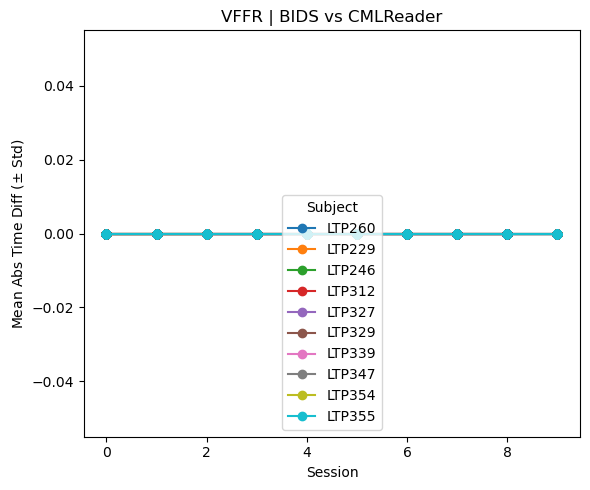

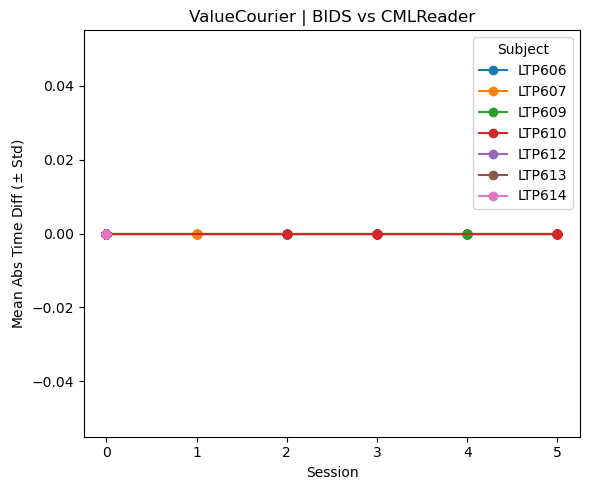

In [3]:
# plot mean and std difference
plot_comp_results(df_time_all, "mean_abs_time_diff", "std_time_diff", col_label="Mean Abs Time Diff")

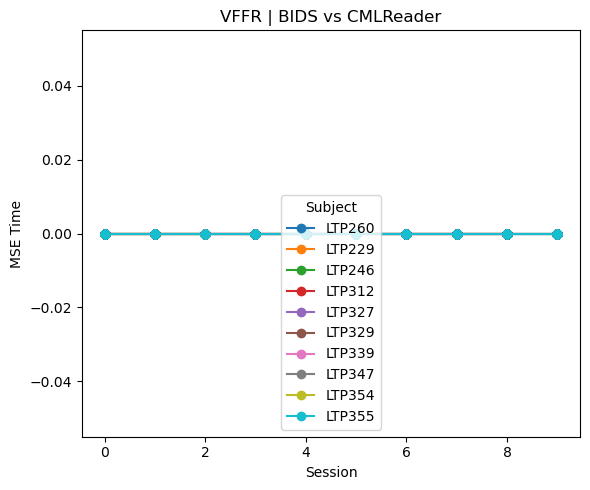

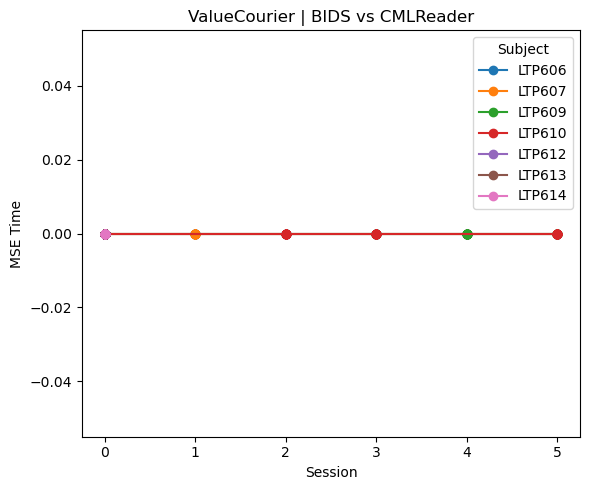

In [4]:
# plot mse
plot_comp_results(df_time_all, "mse_time", col_label="MSE Time")

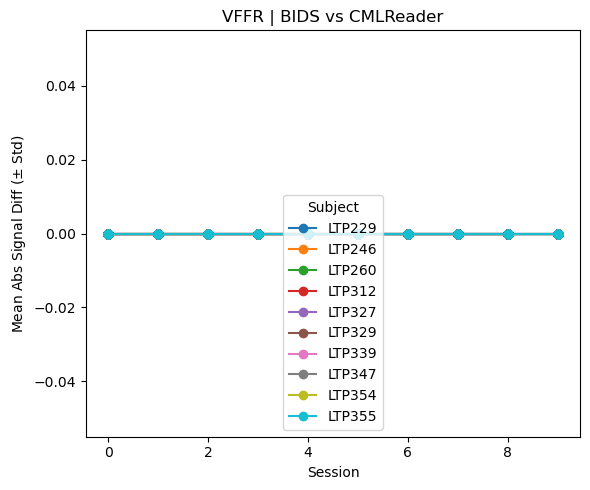

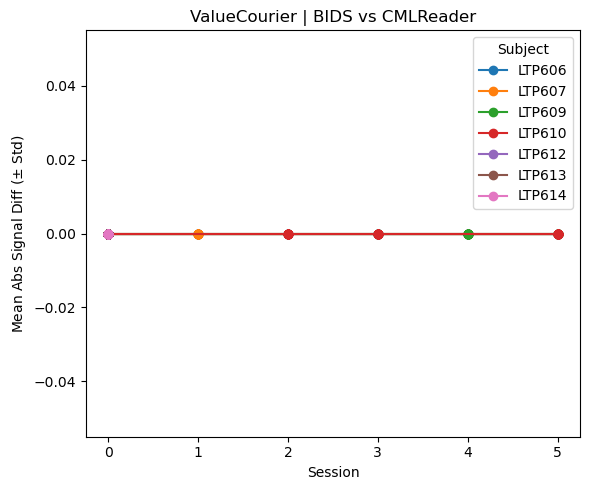

In [5]:
plot_comp_results(df_raw_summary_all, "mean_abs_diff", "std_diff", col_label="Mean Abs Signal Diff")

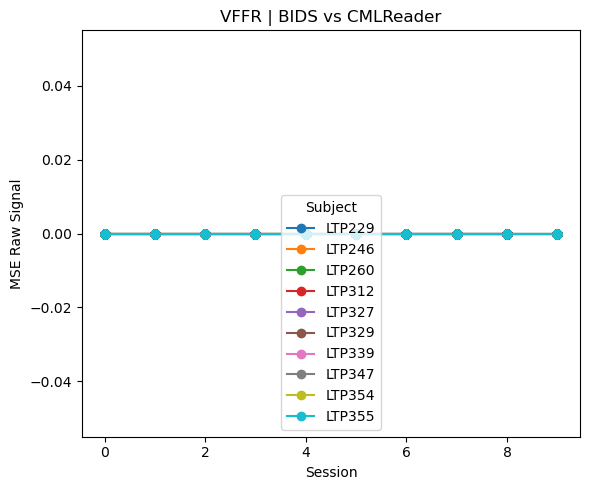

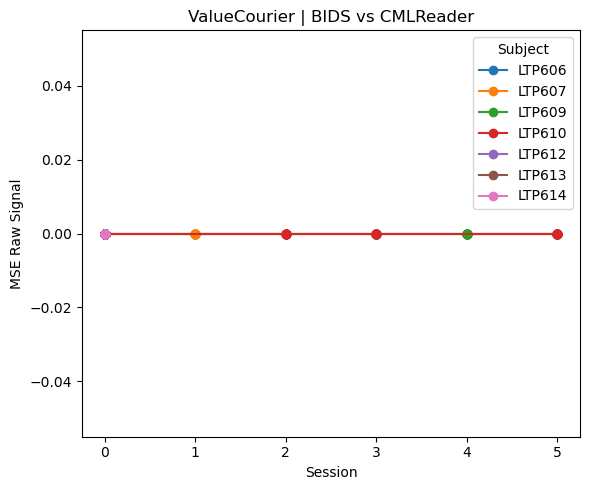

In [6]:
# plot mse
plot_comp_results(df_raw_summary_all, "mse", col_label="MSE Raw Signal")

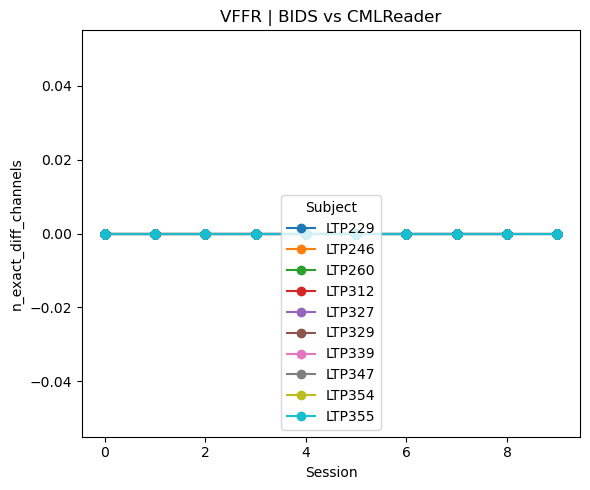

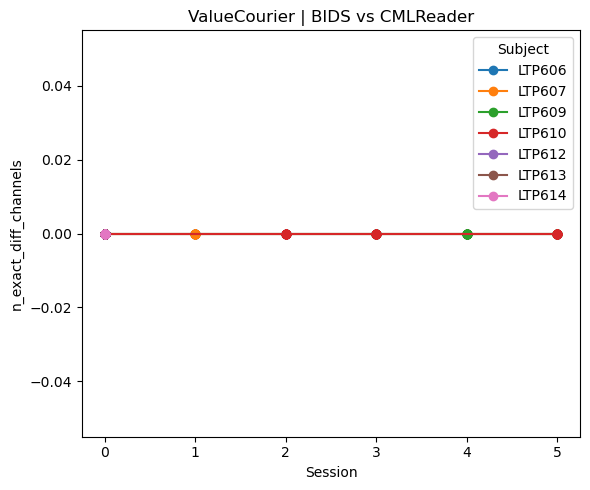

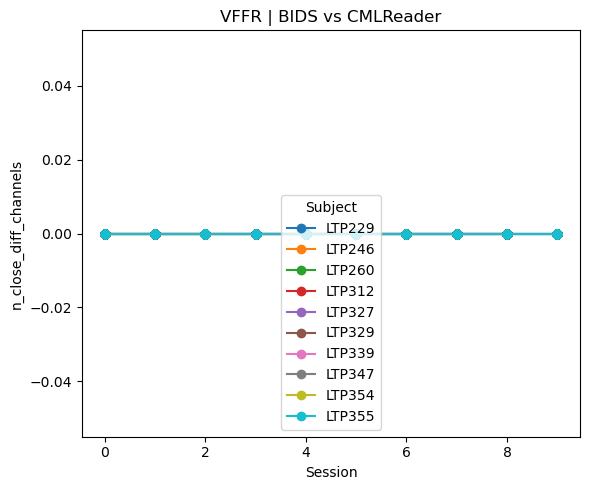

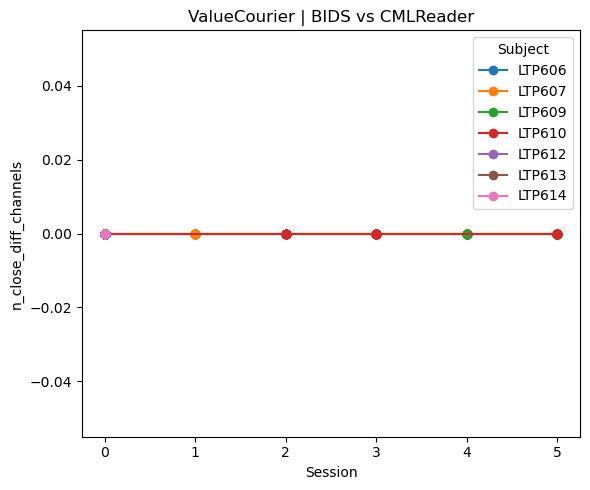

In [7]:
# plot n_channels diff
plot_comp_results(df_raw_summary_all, "n_exact_diff_channels")
plot_comp_results(df_raw_summary_all, "n_close_diff_channels")

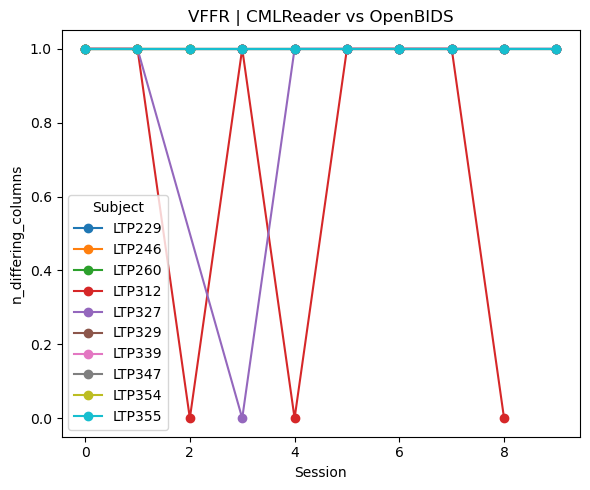

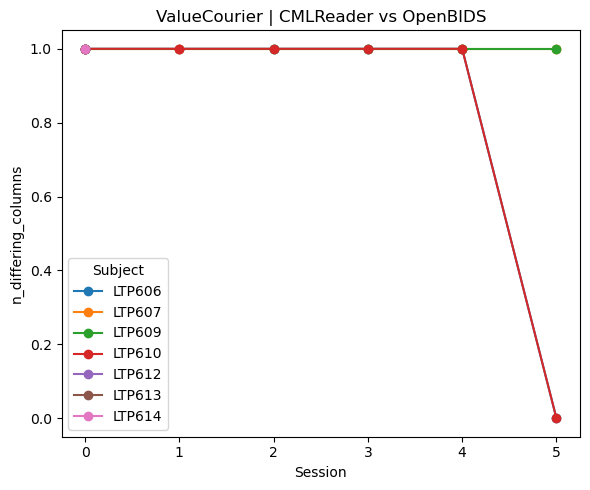

In [8]:
plot_comp_results(df_behavior_summary_all, "n_differing_columns")